<a href="https://colab.research.google.com/github/JHYUIHGY/ECE_204/blob/main/notebooks/run_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

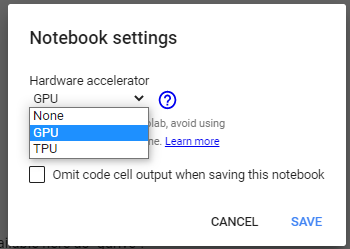

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


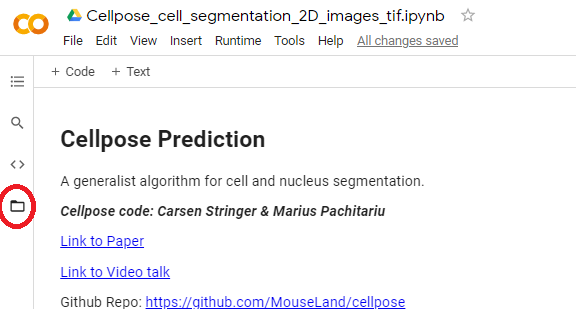

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

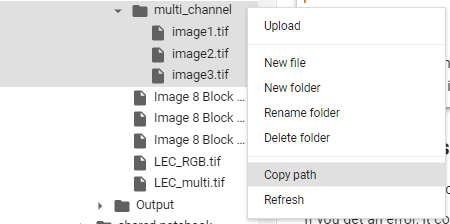

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [2]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-dlgwo9lc
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-dlgwo9lc
  Resolved https://www.github.com/mouseland/cellpose.git to commit 9d59b2eec1d644fb3d4ba0f77ff19ae2900ab706
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00


Check GPU and instantiate model - will download weights.

In [3]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.11.12 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


creating new log file
2025-05-21 17:49:55,339 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-05-21 17:49:55,339 [INFO] 
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.11.12 
torch version:  	2.6.0+cu124
2025-05-21 17:49:55,565 [INFO] ** TORCH CUDA version installed and working. **
2025-05-21 17:49:55,566 [INFO] ** TORCH CUDA version installed and working. **
2025-05-21 17:49:55,567 [INFO] >>>> using GPU (CUDA)
2025-05-21 17:49:58,380 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:02<00:00, 425MB/s]


Input directory with your images:

In [4]:
from pathlib import Path
from PIL import Image

# --- Helper function to convert PNG to .tif ---
def convert_png_to_tif_in_folder(folder_path: Path):
    """
    Converts all PNG images in a specified folder to .tif format.
    Uses pathlib.Path for path operations. .tif files are saved in the same folder.
    Skips conversion if a corresponding .tif file already exists.

    Args:
        folder_path (Path): The path object of the folder containing the PNG images.
    """
    if not folder_path.is_dir():
        print(f"Error during conversion: Folder '{folder_path}' not found or is not a directory.")
        return

    print(f"\n--- Starting PNG to .tif conversion in folder: {folder_path} ---")
    converted_count = 0
    skipped_existing_tif_count = 0
    error_count = 0
    png_files_found = 0

    for item in folder_path.iterdir():
        if item.is_file() and item.suffix.lower() == ".png":
            png_files_found += 1
            png_path = item
            # Output file will have .tif extension
            tif_path = png_path.with_suffix(".tif")

            if tif_path.exists():
                # print(f".tif version '{tif_path.name}' already exists for '{png_path.name}'. Skipping conversion.")
                skipped_existing_tif_count += 1
                continue

            try:
                img = Image.open(png_path)

                save_all_frames = False
                if hasattr(img, 'n_frames') and img.n_frames > 1:
                    save_all_frames = True

                # Pillow's format name is "TIFF", even for .tif extension
                img.save(tif_path, format="TIFF", save_all=save_all_frames, compression="tiff_lzw")
                print(f"Converted '{png_path.name}' to '{tif_path.name}'")
                converted_count += 1
            except Exception as e:
                print(f"Could not convert '{png_path.name}'. Error: {e}")
                error_count += 1

    print(f"--- PNG to .tif conversion finished ---")
    if png_files_found == 0:
        print("No PNG files found in the directory for conversion.")
    else:
        if converted_count > 0:
            print(f"Successfully converted {converted_count} PNG image(s) to .tif.")
        if skipped_existing_tif_count > 0:
            print(f"{skipped_existing_tif_count} PNG image(s) already had corresponding .tif versions and were skipped.")
        if error_count > 0:
            print(f"Encountered errors for {error_count} PNG image(s) during conversion.")
        if converted_count == 0 and skipped_existing_tif_count == png_files_found and error_count == 0 :
             print("All PNG files already have corresponding .tif versions or no new PNGs to convert.")
    print("----------------------------------------\n")

# --- Helper function to delete all non-.tif files ---
def delete_non_tif_files(folder_path: Path):
    """
    Deletes all files in the specified folder except for .tif files.
    WARNING: This operation is destructive and irreversible.

    Args:
        folder_path (Path): The path object of the folder to clean up.
    """
    if not folder_path.is_dir():
        print(f"Error during deletion: Folder '{folder_path}' not found or is not a directory.")
        return

    print(f"\n--- Starting deletion of non-.tif files in folder: {folder_path} ---")
    print("WARNING: This will delete all files except those with the .tif extension.")
    deleted_count = 0
    kept_count = 0
    error_delete_count = 0

    for item in folder_path.iterdir():
        if item.is_file():  # Only process files
            if item.suffix.lower() != ".tif":
                try:
                    item.unlink()  # Delete the file
                    print(f"Deleted: {item.name}")
                    deleted_count += 1
                except Exception as e:
                    print(f"Error deleting {item.name}: {e}")
                    error_delete_count +=1
            else:
                kept_count += 1
        # This function does not delete subdirectories, only files.

    print(f"--- File deletion finished ---")
    if deleted_count > 0:
        print(f"Successfully deleted {deleted_count} non-.tif file(s).")
    else:
        print("No non-.tif files found to delete (or only .tif files were present).")
    if error_delete_count > 0:
        print(f"Failed to delete {error_delete_count} file(s).")
    print(f"Kept {kept_count} .tif file(s).")
    print("----------------------------\n")

# --- original script logic starts below ---

# *** change to your google drive folder path ***
directory_path_str = "/content/drive/MyDrive/BMRB_images" # Example path
directory_path = Path(directory_path_str)

if not directory_path.exists():
  raise FileNotFoundError(f"Directory '{directory_path}' does not exist. Please check the path.")
if not directory_path.is_dir():
  raise NotADirectoryError(f"Path '{directory_path}' is not a directory. Please check the path.")

# 1. Convert PNG files to .tif files
convert_png_to_tif_in_folder(directory_path)

# 2. Delete all other files except .tif files from the directory
#    (This includes original PNGs if conversion was successful, and any other file types)
delete_non_tif_files(directory_path)

# *** image extension to look for (should be .tif) ***
image_ext = ".tif"

# 3. List all remaining .tif files, excluding masks and flows
files = natsorted([
    f for f in directory_path.glob("*" + image_ext)
    if "_masks" not in f.name and "_flows" not in f.name
])

if not files:
  print(f"No image files with extension '{image_ext}' (excluding '_masks' and '_flows') found in '{directory_path}'.")
  print("This could be due to various reasons: no initial .tif files, no PNGs to convert, all files filtered out, or issues during conversion/deletion.")
else:
  print(f"{len(files)} images with extension '{image_ext}' (excluding '_masks' and '_flows') found in folder '{directory_path}':")

for f_path in files:
  print(f_path.name)


--- Starting PNG to .tif conversion in folder: /content/drive/MyDrive/BMRB_images ---
--- PNG to .tif conversion finished ---
No PNG files found in the directory for conversion.
----------------------------------------


--- Starting deletion of non-.tif files in folder: /content/drive/MyDrive/BMRB_images ---
--- File deletion finished ---
No non-.tif files found to delete (or only .tif files were present).
Kept 607 .tif file(s).
----------------------------

607 images with extension '.tif' (excluding '_masks' and '_flows') found in folder '/content/drive/MyDrive/BMRB_images':
fig1_s12104-007-9002-7.tif
fig1_s12104-007-9003-6.tif
fig1_s12104-007-9004-5.tif
fig1_s12104-007-9005-4.tif
fig1_s12104-007-9007-2.tif
fig1_s12104-007-9009-0.tif
fig1_s12104-007-9011-6.tif
fig1_s12104-007-9012-5.tif
fig1_s12104-007-9013-4.tif
fig1_s12104-007-9015-2.tif
fig1_s12104-007-9017-0.tif
fig1_s12104-007-9018-z.tif
fig1_s12104-007-9019-y.tif
fig1_s12104-007-9024-1.tif
fig1_s12104-007-9026-z.tif
fig1_s121

## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [5]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (3251, 2622). Assuming channel dimension is last with 2622 channels


### Channel Selection:

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

In [5]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]

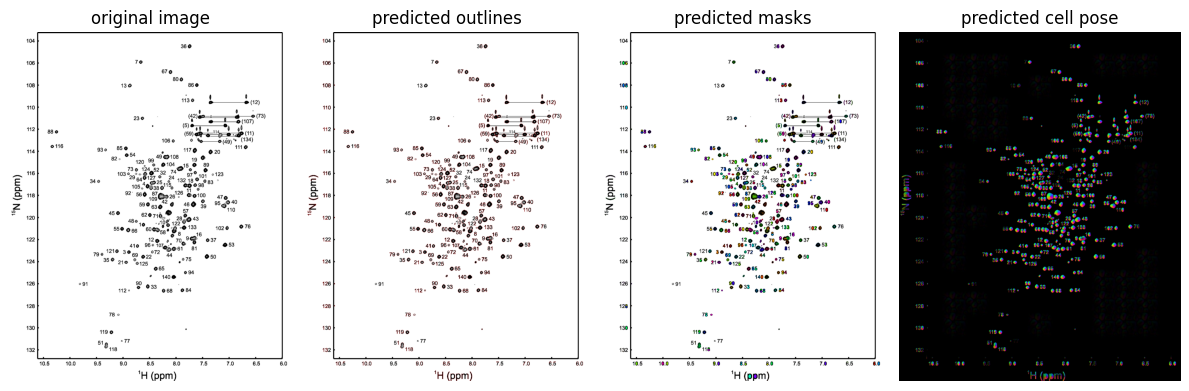

In [15]:
import os

# 1.  Make sure the image has a channel axis
img = io.imread(files[0])          # (H, W)  or  (H, W, C)

if img.ndim == 2:                  # HSQC → single-channel
    img = img[..., None]           # (H, W, 1)

n_channels = img.shape[-1]         # now always ≥ 1


# 2.  Parse the dropdowns and validate indices
selected_channels = []
for c in [first_channel, second_channel, third_channel]:
    if c == 'None':
        continue
    idx = int(c)
    assert 0 <= idx < n_channels, (
        f'Invalid channel index {idx}; image has only {n_channels} channel(s).'
    )
    selected_channels.append(idx)

# Fallback: if the user picked nothing, just use the first channel
if not selected_channels:
    selected_channels = [0]


# 3.  Build the input volume for Cellpose
img_selected_channels = img[..., selected_channels]      # shape (H, W, len(selected))


# 4.  Run Cellpose
flow_threshold       = 0.4
cellprob_threshold   = 0.0
tile_norm_blocksize  = 0

masks, flows, styles = model.eval(
    img_selected_channels,
    batch_size          = 32,
    flow_threshold      = flow_threshold,
    cellprob_threshold  = cellprob_threshold,
    normalize           = {"tile_norm_blocksize": tile_norm_blocksize},
)


# 5.  Visualise and save
fig = plt.figure(figsize=(12, 5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()

os.makedirs("results", exist_ok=True)
plt.imsave("results/segmentation_mask.png", masks, cmap='viridis')
fig.savefig("results/segmentation_overlay.png", dpi=300)


## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [7]:
import matplotlib.pyplot as plt
import os
import imageio.v3 as io
from tqdm import trange
from cellpose import plot
import zipfile
from pathlib import Path


masks_ext = ".png" if image_ext == ".png" else ".tif"

print("loading images")
imgs = []
for i in trange(len(files), desc="Loading images"):
    file_path = files[i]
    imgs.append(io.imread(file_path))

flow_threshold       = 0.4
cellprob_threshold   = 0.0
tile_norm_blocksize  = 0

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks and plots to temporary directory")

# Create a temporary directory to store individual results before zipping
temp_results_dir = Path("./temp_cellpose_results")
os.makedirs(temp_results_dir, exist_ok=True)

# Define subdirectories within the temporary directory
temp_masks_sub_dir = temp_results_dir / "masks"
temp_plots_sub_dir = temp_results_dir / "segmentation_plots"

os.makedirs(temp_masks_sub_dir, exist_ok=True)
os.makedirs(temp_plots_sub_dir, exist_ok=True)

for i in trange(len(files), desc="Saving individual files"):
    f = files[i] # Get the current file's Path object or string

    mask_save_path = temp_masks_sub_dir / (f.stem + "_masks" + masks_ext)
    plot_save_path = temp_plots_sub_dir / (f.stem + "_segmentation_overlay.png")

    io.imwrite(mask_save_path, masks[i])

    fig = plt.figure(figsize=(12, 5))

    img_to_plot = imgs[i]

    # Transpose channels from (Channels, Height, Width) to (Height, Width, Channels) if necessary
    if img_to_plot.ndim == 3 and img_to_plot.shape[0] in [2, 3, 4]:
        img_to_plot = np.transpose(img_to_plot, (1, 2, 0))

    # Convert 2-channel (Height, Width, 2) image to 3-channel (Height, Width, 3) RGB for Matplotlib
    if img_to_plot.ndim == 3 and img_to_plot.shape[-1] == 2:
        img_display = np.zeros((img_to_plot.shape[0], img_to_plot.shape[1], 3), dtype=img_to_plot.dtype)
        img_display[:, :, 0] = img_to_plot[:, :, 0] # Assign first channel to Red
        img_display[:, :, 1] = img_to_plot[:, :, 1] # Assign second channel to Green
        # Blue channel remains zero
    else:
        # Use as is if it's already (H,W) or (H,W,3/4)
        img_display = img_to_plot

    # --- Flow (flow_to_plot) preparation ---
    # `flows` is a list of tuples, where each tuple is for one image:
    # (cell_prob_map, dY, dX, cell_to_interp)

    current_image_flow_tuple = flows[i]

    flow_to_plot = current_image_flow_tuple[0]

    # If, for some reason, the cell probability map itself came in a strange 3D shape (e.g., (H, W, 3))
    # and you still want to force it to grayscale for this particular panel:
    if flow_to_plot.ndim == 3 and flow_to_plot.shape[-1] in [3, 4]:
        # Convert RGB/RGBA to grayscale by averaging channels (common approach)
        flow_to_plot = np.mean(flow_to_plot, axis=-1)

    # If you specifically wanted to plot the magnitude of dY, dX flows:
    # dY_flow = current_image_flow_tuple[1]
    # dX_flow = current_image_flow_tuple[2]
    # flow_to_plot = np.sqrt(dY_flow**2 + dX_flow**2) # This would be a (H, W) array

    plot.show_segmentation(fig, img_display, masks[i], flow_to_plot)

    fig.savefig(plot_save_path, dpi=300)
    plt.close(fig)


print("creating zip archive...")
zip_filename = Path("./cellpose_results.zip")

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_in_dir in os.walk(temp_results_dir):
        for file in files_in_dir:
            file_path = Path(root) / file
            # Arcname is the path inside the zip file
            arcname = file_path.relative_to(temp_results_dir)
            zipf.write(file_path, arcname)

print(f"All results saved to {zip_filename}")

# Clean up the temporary directory
import shutil
try:
    shutil.rmtree(temp_results_dir)
    print(f"Cleaned up temporary directory: {temp_results_dir}")
except OSError as e:
    print(f"Error removing temporary directory {temp_results_dir}: {e}")


loading images



Loading images: 100%|██████████| 607/607 [09:58<00:00,  1.01it/s]

running cellpose-SAM


NameError: name 'flow_threshold' is not defined

In [8]:
flow_threshold       = 0.4
cellprob_threshold   = 0.0
tile_norm_blocksize  = 0

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks and plots to temporary directory")

# Create a temporary directory to store individual results before zipping
temp_results_dir = Path("./temp_cellpose_results")
os.makedirs(temp_results_dir, exist_ok=True)

# Define subdirectories within the temporary directory
temp_masks_sub_dir = temp_results_dir / "masks"
temp_plots_sub_dir = temp_results_dir / "segmentation_plots"

os.makedirs(temp_masks_sub_dir, exist_ok=True)
os.makedirs(temp_plots_sub_dir, exist_ok=True)

for i in trange(len(files), desc="Saving individual files"):
    f = files[i]

    # Define paths for saving within the temporary structure
    mask_save_path = temp_masks_sub_dir / (f.stem + "_masks" + masks_ext)
    plot_save_path = temp_plots_sub_dir / (f.stem + "_segmentation_overlay.png")

    io.imwrite(mask_save_path, masks[i])

    # Plot and save the segmentation overlay
    fig = plt.figure(figsize=(12, 5))
    plot.show_segmentation(fig, imgs[i], masks[i], flows[0][i])

    fig.savefig(plot_save_path, dpi=300)
    plt.close(fig) # Close the figure to free up memory

print("creating zip archive...")
zip_filename = Path("./cellpose_results.zip")

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_in_dir in os.walk(temp_results_dir):
        for file in files_in_dir:
            file_path = Path(root) / file
            # Arcname is the path inside the zip file
            arcname = file_path.relative_to(temp_results_dir)
            zipf.write(file_path, arcname)

print(f"All results saved to {zip_filename}")

# Clean up the temporary directory
import shutil
try:
    shutil.rmtree(temp_results_dir)
    print(f"Cleaned up temporary directory: {temp_results_dir}")
except OSError as e:
    print(f"Error removing temporary directory {temp_results_dir}: {e}")


running cellpose-SAM
2025-05-21 18:05:16,071 [INFO] 
2025-05-21 18:05:16,072 [INFO] 0%|          | 0/607 [00:00<?, ?it/s]
2025-05-21 18:05:16,072 [INFO] 
2025-05-21 18:05:49,137 [INFO] 
2025-05-21 18:05:49,138 [INFO] 3%|2         | 17/607 [00:33<19:07,  1.94s/it]
2025-05-21 18:05:49,138 [INFO] 
2025-05-21 18:06:08,674 [INFO] 
2025-05-21 18:06:08,675 [INFO] 3%|2         | 17/607 [00:52<19:07,  1.94s/it]
2025-05-21 18:06:08,675 [INFO] 
2025-05-21 18:06:19,359 [INFO] 
2025-05-21 18:06:19,360 [INFO] 4%|4         | 25/607 [01:03<26:00,  2.68s/it]
2025-05-21 18:06:19,360 [INFO] 
2025-05-21 18:06:23,928 [WARNING] Found more than 3 channels, only using first 3
2025-05-21 18:06:38,684 [INFO] 
2025-05-21 18:06:38,685 [INFO] 4%|4         | 25/607 [01:22<26:00,  2.68s/it]
2025-05-21 18:06:38,686 [INFO] 
2025-05-21 18:06:43,468 [WARNING] Found more than 3 channels, only using first 3
2025-05-21 18:06:52,397 [INFO] 
2025-05-21 18:06:52,398 [INFO] 6%|6         | 39/607 [01:36<23:51,  2.52s/it]
2025-0

Loading images:   0%|          | 0/607 [14:50<?, ?it/s]


2025-05-21 18:07:23,341 [INFO] 
2025-05-21 18:07:23,342 [INFO] 9%|9         | 55/607 [02:07<20:45,  2.26s/it]
2025-05-21 18:07:23,343 [INFO] 
2025-05-21 18:07:33,877 [WARNING] Found more than 3 channels, only using first 3
2025-05-21 18:07:35,435 [WARNING] Found more than 3 channels, only using first 3
2025-05-21 18:07:38,690 [INFO] 
2025-05-21 18:07:38,691 [INFO] 9%|9         | 55/607 [02:22<20:45,  2.26s/it]
2025-05-21 18:07:38,692 [INFO] 
2025-05-21 18:07:43,477 [WARNING] Found more than 3 channels, only using first 3
2025-05-21 18:07:53,769 [INFO] 
2025-05-21 18:07:53,770 [INFO] 12%|#2        | 73/607 [02:37<17:58,  2.02s/it]
2025-05-21 18:07:53,770 [INFO] 
2025-05-21 18:07:59,545 [WARNING] Found more than 3 channels, only using first 3
2025-05-21 18:08:07,310 [WARNING] Found more than 3 channels, only using first 3
2025-05-21 18:08:08,694 [INFO] 
2025-05-21 18:08:08,695 [INFO] 12%|#2        | 73/607 [02:52<17:58,  2.02s/it]
2025-05-21 18:08:08,695 [INFO] 
2025-05-21 18:08:23,954 [

Saving individual files:   0%|          | 0/607 [00:00<?, ?it/s]


AttributeError: module 'imageio.v3' has no attribute 'imsave'

In [1]:
for i in trange(len(files), desc="Saving individual files"):
    f = files[i] # Get the current file's Path object or string

    mask_save_path = temp_masks_sub_dir / (f.stem + "_masks" + masks_ext)
    plot_save_path = temp_plots_sub_dir / (f.stem + "_segmentation_overlay.png")

    io.imwrite(mask_save_path, masks[i])

    fig = plt.figure(figsize=(12, 5))

    img_to_plot = imgs[i]

    # Transpose channels from (Channels, Height, Width) to (Height, Width, Channels) if necessary
    if img_to_plot.ndim == 3 and img_to_plot.shape[0] in [2, 3, 4]:
        img_to_plot = np.transpose(img_to_plot, (1, 2, 0))

    # Convert 2-channel (Height, Width, 2) image to 3-channel (Height, Width, 3) RGB for Matplotlib
    if img_to_plot.ndim == 3 and img_to_plot.shape[-1] == 2:
        img_display = np.zeros((img_to_plot.shape[0], img_to_plot.shape[1], 3), dtype=img_to_plot.dtype)
        img_display[:, :, 0] = img_to_plot[:, :, 0] # Assign first channel to Red
        img_display[:, :, 1] = img_to_plot[:, :, 1] # Assign second channel to Green
        # Blue channel remains zero
    else:
        # Use as is if it's already (H,W) or (H,W,3/4)
        img_display = img_to_plot

    # --- Flow (flow_to_plot) preparation ---
    # `flows` is a list of tuples, where each tuple is for one image:
    # (cell_prob_map, dY, dX, cell_to_interp)

    current_image_flow_tuple = flows[i]

    flow_to_plot = current_image_flow_tuple[0]

    # If, for some reason, the cell probability map itself came in a strange 3D shape (e.g., (H, W, 3))
    # and you still want to force it to grayscale for this particular panel:
    if flow_to_plot.ndim == 3 and flow_to_plot.shape[-1] in [3, 4]:
        # Convert RGB/RGBA to grayscale by averaging channels (common approach)
        flow_to_plot = np.mean(flow_to_plot, axis=-1)

    # If you specifically wanted to plot the magnitude of dY, dX flows:
    # dY_flow = current_image_flow_tuple[1]
    # dX_flow = current_image_flow_tuple[2]
    # flow_to_plot = np.sqrt(dY_flow**2 + dX_flow**2) # This would be a (H, W) array

    plot.show_segmentation(fig, img_display, masks[i], flow_to_plot)

    fig.savefig(plot_save_path, dpi=300)
    plt.close(fig)


print("creating zip archive...")
zip_filename = Path("./cellpose_results.zip")

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_in_dir in os.walk(temp_results_dir):
        for file in files_in_dir:
            file_path = Path(root) / file
            # Arcname is the path inside the zip file
            arcname = file_path.relative_to(temp_results_dir)
            zipf.write(file_path, arcname)

print(f"All results saved to {zip_filename}")

# Clean up the temporary directory
import shutil
try:
    shutil.rmtree(temp_results_dir)
    print(f"Cleaned up temporary directory: {temp_results_dir}")
except OSError as e:
    print(f"Error removing temporary directory {temp_results_dir}: {e}")


NameError: name 'trange' is not defined

to save your masks for ImageJ, run the following code:

In [ ]:
for i in trange(len(files)):
    f = files[i]
    masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
    io.save_rois(masks0, f)